## Digital Analyst (CRO) - Project

Description:
The product owner wants to improve the registration journey for mcluck.com users. He has an idea that splitting the manual sign-up form from 1 step to 3 steps will improve the sign-up conversion rate. He is also interested in the impact of this change on purchasing behaviour (first purchase).

## Objectives

To help the product owner make a decision, we need to identify two elements:

> ### First
> To determine the conversion rate, we compare the number of visitors who signed up to the total number of visitors exposed to each variant of the experiment, in both the original and multistep forms.

> ### Second 
> - To find the proportion of first-time purchasers compared to signed-up visitors in both variants.
> - To identify the purchase value in both variants.

### Data
 

Three datasets are available for this analysis as described [here](https://github.com/AdnanAbed/Attachments/blob/1c0ea1ab4451901bd7d17199666cad0c81d07f82/CRO_Data%20Description.pdf )

### Analysis for first objective

Let's do the analysis considering the hypothesis below:

Null Hypothesis (H₀): The null hypothesis states that there is no significant difference between the conversion rate of the two variants of the sign-up forms.  

Alternative Hypothesis (H₁): The alternative hypothesis suggests a significant difference in the conversion rates between the two variants of the sign-up forms.

In [3]:
# Step 1: Importing necessary libraries and loading the datasets

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load data into DataFrames (assuming CSV files for this example)
decisions = pd.read_csv('decisions.csv')
conversions = pd.read_csv('conversions.csv')
account_details = pd.read_csv('account_details.csv')


In [5]:
# Filter relevant data
decisions_filtered = decisions[decisions['variation_id'].isin([25991400310, 25974540423])]
conversions_filtered = conversions[conversions['variation_id'].isin([25991400310, 25974540423])]


In [7]:
# Step 2: Analyze Sign-Up Conversion Rate

# Identify sign-up events for both variations as a df
sign_ups = conversions_filtered[conversions_filtered['event_name'] == 'signUp']

# Count unique visitors for each variation
filtered_visitors = decisions_filtered[decisions_filtered['visitor_id'] != 0]
unique_visitors = decisions_filtered.groupby('variation_id')['visitor_id'].nunique()

# Count sign-ups for each variation
sign_up_counts = sign_ups.groupby('variation_id')['visitor_id'].nunique()

# Calculate conversion rates
conversion_rates = sign_up_counts / unique_visitors

# Create a DataFrame to display the results as a table
results = pd.DataFrame({
    'Variation_id': unique_visitors.index,
    'Unique visitors': unique_visitors.values,
    'Sign_up counts': sign_up_counts.values,
    'Conversion rate': conversion_rates.values
})

# Print the table
print(results)

## Variation_id 25974540423 is for the Multi_step Form
## Variation_id 25991400310 is for the Orignial Form


   Variation_id  Unique visitors  Sign_up counts  Conversion rate
0   25974540423             7642            3934         0.514787
1   25991400310             7721            3940         0.510297


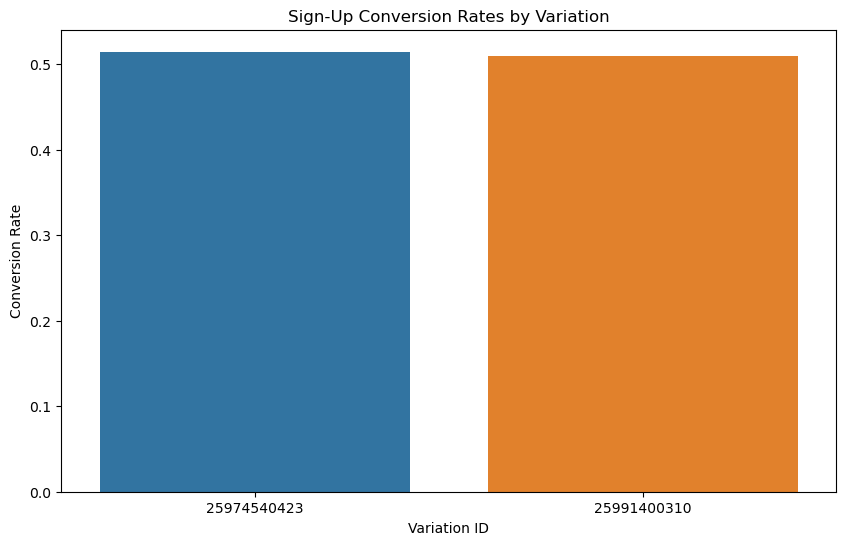

In [11]:
# Plot Conversion Rates
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values)
plt.title('Sign-Up Conversion Rates by Variation')
plt.xlabel('Variation ID')
plt.ylabel('Conversion Rate')
plt.show()


In [48]:
# Step 4: Statistical Significance (using Chi-Square Test for Proportions)

import scipy.stats as stats
import math

# Given data
n1 = 7721 # number of visitors for the original form
n2 = 7642  # number of visitors for the multi-step form
p1 = 0.510297 # conversion rate for the original form
p2 = 0.514787 # conversion rate for the multi-step form

# Calculate number of conversions
x1 = n1 * p1
x2 = n2 * p2

# Calculate pooled proportion
p_pooled = (x1 + x2) / (n1 + n2)

# Calculate standard error
SE = math.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

# Calculate z-score
z = (p2 - p1) / SE

# Calculate p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"z-score: {z}")
print(f"p-value: {p_value}")



z-score: 0.5566920718191339
p-value: 0.5777378346579753


A p-value of 0.5888 suggests that there is a high probability that the observed difference (or a more extreme one) could have occurred by random chance alone, assuming that the null hypothesis is true.

### Analysis for the second objective

Let's do the analysis considering the hypothesis below:

Null Hypothesis (H₀): The null hypothesis states that there is no significant difference between the proportion of sign-up counts and first purchase counts for the two variants.  

Alternative Hypothesis (H₁): The alternative hypothesis suggests a significant difference in the conversion rates between the proportion of sign-up counts and first purchase counts for the two variants.

In [23]:
# Step 1: Re-Calculate sign_up_count
sign_up_count = (
    conversions[conversions['event_name'] == 'signUp']
    .groupby('variation_id')
    .agg(signup_count=('visitor_id', 'nunique'))
    .reset_index()
)

# Step 2: Merge the data frames on account_id and user_account_id
merged_df = pd.merge(
    conversions,
    account_details,
    left_on='user_account_id',
    right_on='account_id',
    how='inner'
)

# Step 3: Remove duplicates based on user_account_id
merged_df = merged_df.drop_duplicates(subset=['user_account_id'])

# Step 4: Calculate the sum of first_purchase_value where sign_up_method = 'manual', grouped by variation_id
sum_first_purchase = merged_df[merged_df['sign_up_method'] == 'manual'].groupby('variation_id')['first_purchase_value'].sum().reset_index()

# Step 5: Count first_purchase_value where sign_up_method = 'manual' and first_purchase_value != 0, grouped by variation_id
count_1st_Purchasers = merged_df[(merged_df['sign_up_method'] == 'manual') & (merged_df['first_purchase_value'] != 0)].groupby('variation_id')['first_purchase_value'].count().reset_index()
count_1st_Purchasers = count_1st_Purchasers.rename(columns={'first_purchase_value': 'count_1st_Purchasers'})

# Step 6: Merge the sign_up_count, sum_first_purchase, and count_nonzero_first_purchase DataFrames
result = pd.merge(sign_up_count, sum_first_purchase, on='variation_id', how='left')
result = pd.merge(result, count_1st_Purchasers, on='variation_id', how='left')

# Step 7: Calculate the Purchase_rate
result['Purchase_rate'] = result['count_1st_Purchasers'] / result['signup_count']

# Step 8: Print the results
print(result[['variation_id', 'signup_count', 'count_1st_Purchasers', 'first_purchase_value', 'Purchase_rate']].to_string(index=False))



 variation_id  signup_count  count_1st_Purchasers  first_purchase_value  Purchase_rate
  25974540423          3934                   406               6765.94       0.103203
  25991400310          3940                   444               6490.56       0.112690


Plotting the results and testing the significance

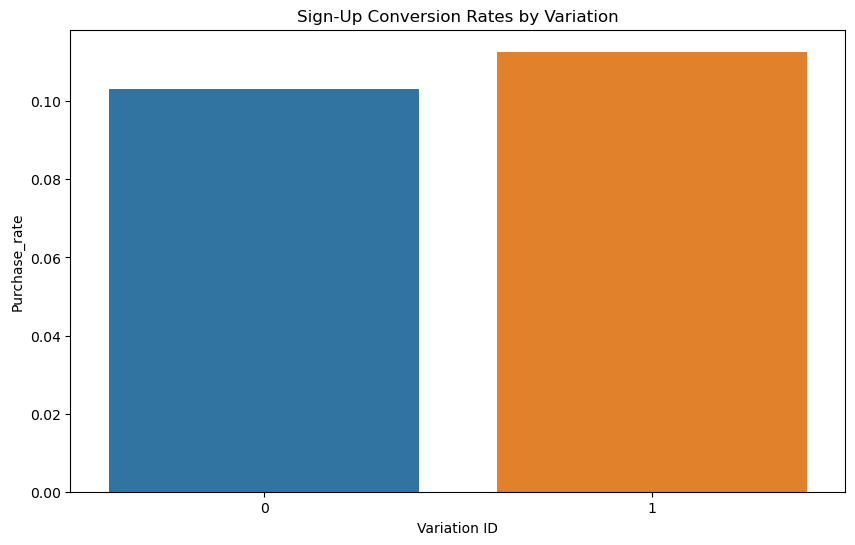

In [35]:

plt.figure(figsize=(10, 6))
sns.barplot(x=result['Purchase_rate'].index, y=result['Purchase_rate'].values)
plt.title('Sign-Up Conversion Rates by Variation')
plt.xlabel('Variation ID')
plt.ylabel('Purchase_rate')
plt.show()

In [52]:
# Step 4: Statistical Significance (using Chi-Square Test for Proportions)

import scipy.stats as stats
import math

# Given data
n1 = 3940 # number of sign-up for the original form
n2 = 3934  # number of sign_ups for the multi-step form
p1 = 0.112690 # Purchase rate for the original form
p2 = 0.103203 # Purchase rate for the multi-step form

# Calculate number of conversions
x1 = n1 * p1
x2 = n2 * p2

# Calculate pooled proportion
p_pooled = (x1 + x2) / (n1 + n2)

# Calculate standard error
SE = math.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))

# Calculate z-score
z = (p2 - p1) / SE

# Calculate p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"z-score: {z}")
print(f"p-value: {p_value}")



z-score: -1.3564080526162499
p-value: 0.17496937255558365


## Conclusion

- Despite the variations in conversion rates between the two variants and the disparities in the proportion of first-purchase counts and sign-up counts, these differences are not statistically significant. This indicates that there is a high probability that the observed difference, or an even more extreme one, could have occurred purely by random chance.
- Recommendation: consider further testing or optimization.

## Recommendation
To effectively measure the impact of modifying a one-stage sign-up form to a three-stage sign-up form on conversion rates, it is recommended to collect various digital metrics. Here are the key metrics to focus on:

1. Conversion Rate Metr    ics
 - Overall Conversion Rate: Measure the percentage of users who complete the sign-up proc    ess.
 - Stage-Specific Conversion Rates: Measure the drop-off rate at each stage of the sign-up pro    cess.
 - Stage 1 to Stage 2 Conversio    n Rate
 - Stage 2 to Stage 3 Conversi    on Rate
 - Stage 3 to Completion Conversion Rate

2. Funn    el Metrics
 - Funnel Drop-off Rates: The percentage of users who abandon the sign-up process at     each stage.
 - Time to Complete Each Stage: Average time users spend on each stage of the form.

3. User Be    havior Metrics
 - Form Field Interaction: Track interactions with each form field to identify prob    lematic fields.
 - Metrics: Number of clicks, time spent, error rates, and corr    ection attempts.
 - Session Duration: Total time users spend on the sign-up process.
4.     Engagement Metrics
 - Page Views per Session: Number of pages viewed during t    he sign-up process.
 - Bounce Rate: Percentage of users who leave the site without interacting further.
5. Us    er Experience Metrics
 - Heatmaps and Click Maps: Visual representations of user interactions at e    ach stage of the form.
 - Session Recordings: Videos of user sessions to observe navigation patterns and issues.    

6. Qualitative Metrics
 - User Feedback: Collect feedback through surveys or feedback forms at the e    nd of the sign-up process.
 - Usability Testing: Conduct tests with real users to gather insights into the user experience.on Rate into the user experience.
